# Laboratorio: Predizione Indice di Borsa (parte 1)

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
nome.cognome@unibo.it

## Serie Storiche

Una _serie storica_ indica l'andamento nel tempo di una generica variabile
- è costituita da una sequenza di valori, ciascuno etichettato con una "timestamp" che indica a quando si riferisce
- i valori possono essere rilevati con cadenza giornaliera, settimanale, ...

Molti esempi di serie storiche si hanno in economia e finanza, con variabili quali il valore di un'azione, il valore di una risorsa (oro, petrolio, ...), il tasso di cambio tra due valute, ...

## Predizione di un'Indice di Borsa

Un _indice_ in borsa costituisce la sintesi del valore di diversi titoli azionari (_componenti_): il valore dell'indice è una media (di solito ponderata) dei valori dei singoli titoli

In questa esercitazione consideriamo l'indice _Standard & Poor 500_ (S&P 500), che ha per componenti [circa 500 grandi aziende degli USA](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies), incluse ad es. Alphabet (Google), Facebook, Apple, ...

L'obiettivo dell'esercitazione è generare modelli in grado di prevedere quanto più accuratamente possibile l'andamento dell'indice S&P 500, in modo tale da massimizzare il guadagno ottenuto investendo in un fondo che si basi su tale indice

## Estrazione Dati

I dati storici sull'andamento di S&P 500 e altri indici e titoli di borsa sono disponibili su diversi siti specializzati, ad es. [Yahoo! Finance](https://finance.yahoo.com/)

Il file `SP500-2001-2005.csv` contiene l'andamento di S&P 500 dall'inizio del 2001 alla fine del 2005

Eseguire la seguente cella per scaricare il file nel caso non sia già presente nella directory corrente

In [2]:
import os
from urllib.request import urlretrieve
if not os.path.exists("SP500-2001-2005.csv"):
    urlretrieve("https://raw.githubusercontent.com/datascienceunibo/dialab2019/master/bozza_Predizione_Borsa/SP500-2001-2005.csv", "SP500-2001-2005.csv")

Per ottenere questo file da Yahoo! Finance abbiamo cercato il titolo "S&P 500" (simbolo GSPC), selezionato la sezione "Historical Data", filtrato sul periodo da "1/1/2001" a "12/31/2005" e cliccato su "Download Data" per scaricare il CSV

Carichiamo ora il file in forma di DataFrame pandas
- con `parse_dates=["Date"]` indichiamo a pandas di interpretare i valori nella colonna `Date` come date piuttosto che come stringhe generiche, pandas riconosce alcuni formati tra cui `YYYY-MM-DD`

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
sp500 = pd.read_csv("SP500-2001-2005.csv", parse_dates=["Date"])

## Interpretazione dei Dati

Visualizziamo alcune righe dei dati per vederne la struttura

In [5]:
sp500.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000
1,2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000
2,2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000
3,2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000
4,2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000


La colonna `Date` indica la data a cui si riferisce ciascuna riga, per cui è opportuno impostarla come indice

In [6]:
sp500.set_index("Date", inplace=True)

I significati delle altre colonne sono invece i seguenti:
- `Open` indica il valore del titolo all'apertura del mercato (tutti i valori sono in USD)
- `Close` indica il valore alla chiusura del mercato
- `High` e `Low` indicano il valore massimo e minimo raggiunti dal titolo nell'arco della giornata
- `Adj Close` è una versione corretta del prezzo di chiusura, che in questo dataset è sempre uguale a `Close`
- `Volume` indica il numero totale di titoli scambiati durante quel giorno 

## Grafico dell'Andamento

Con pandas possiamo facilmente visualizzare l'andamento nel tempo dei valori della tabella: prendiamo ad es. come riferimento il valore di apertura (`Open`)

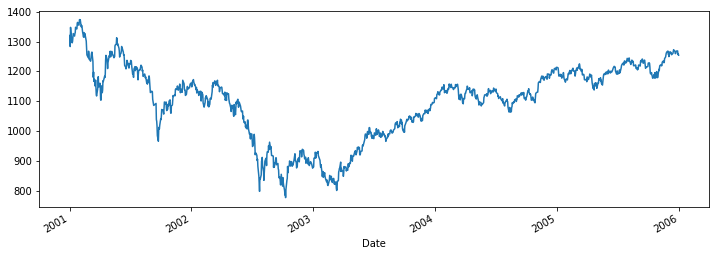

In [13]:
sp500["Open"].plot(figsize=(12, 4))

## Obiettivo: Prevedere Salita o Discesa del Valore

Dai valori $O$ di apertura (`Open`) e $C$ di chiusura (`Close`) di ogni giorno possiamo definire la variazione percentuale del valore come

$$ 100\cdot\frac{C-O}{O} $$

Aggiungiamo una colonna con questo valore al dataset

In [7]:
sp500["PercReturn"] = 100 * (sp500["Close"] - sp500["Open"]) / sp500["Open"]

Visioniamo il dataset dopo le modifiche applicate

In [8]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume,PercReturn
Date,,,,,,,
2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000,-2.803194
2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000,5.009861
2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000,-1.055247
2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000,-2.624236
2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000,-0.191781


Il nostro obiettivo è, all'inizio di ogni giorno, prevedere se il relativo `PercReturn` sarà positivo ($C>O$, valore in salita) o negativo ($C<O$, valore in discesa)

## Estrazione delle Feature Predittive

Per effettuare la predizione, ci servono degli indicatori il cui valore sia noto all'inizio di ogni giornata

A questo scopo possiamo usare i valori della tabella relativi alle date antecedenti: al giorno $d$ consideriamo l'andamento del titolo ai giorni $x-1$, $x-2$, ...

### Il metodo `shift`

Il metodo `shift` crea una copia di una serie con i valori slittati in avanti di un numero di righe indicato, lasciando fisse le etichette (in questo caso le date)

Creiamo ad esempio un DataFrame con la colonna `Open` della tabella sopra e la sua versione `OpenLag2` ritardata di due giorni

In [15]:
pd.DataFrame({
    "Open":     sp500["Open"],
    "OpenLag2": sp500["Open"].shift(2)
}).head(5)

,Open,OpenLag2
Date,,
2001-01-02,1320.280029,NaN
2001-01-03,1283.270020,NaN
2001-01-04,1347.560059,1320.280029
2001-01-05,1333.339966,1283.270020
2001-01-08,1298.349976,1347.560059


La seconda colonna ha gli stessi valori della prima, ma slittati in avanti di due giorni; nelle prime due righe ci sono valori mancanti

### Estrazione variabili predittive

Usiamo il metodo `shift` per creare 5 serie `Lag1`, ..., `Lag5` con i valori della colonna `PercReturn` ritardati da 1 a 5 giorni

In [20]:
lagged_cols = {"Lag{}".format(days): sp500["PercReturn"].shift(days)
               for days in range(1, 6)}

Usiamo queste serie per creare un nuovo DataFrame `X` dove inserire tutte le variabili per la predizione

In [21]:
X = pd.DataFrame(lagged_cols)

Aggiungiamo a `X` anche una colonna `VolumeLag1` col volume del giorno precedente
- dividiamo i valori per $10^9$ in modo da avere una scala simile alle altre colonne

In [22]:
X["VolumeLag1"] = sp500["Volume"].shift(1) / 1e9

Abbiamo ottenuto così il seguente DataFrame

In [23]:
X.head(7)

,Lag1,Lag2,Lag3,Lag4,Lag5,VolumeLag1
Date,,,,,,
2001-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,-2.803194,NaN,NaN,NaN,NaN,1.1294
2001-01-04,5.009861,-2.803194,NaN,NaN,NaN,1.8807
2001-01-05,-1.055247,5.009861,-2.803194,NaN,NaN,2.1310
2001-01-08,-2.624236,-1.055247,5.009861,-2.803194,NaN,1.4308
2001-01-09,-0.191781,-2.624236,-1.055247,5.009861,-2.803194,1.1155
2001-01-10,0.381219,-0.191781,-2.624236,-1.055247,5.009861,1.1913


Nelle prime righe del dataset rimangono valori mancanti (_NaN_, Not a Number): usiamo il metodo `dropna` per rimuovere le righe in cui sono presenti
- `inplace=True` indica di modificare l'oggetto `X` piuttosto che crearne uno nuovo

In [24]:
X.dropna(inplace=True)

In [25]:
X.head()

,Lag1,Lag2,Lag3,Lag4,Lag5,VolumeLag1
Date,,,,,,
2001-01-09,-0.191781,-2.624236,-1.055247,5.009861,-2.803194,1.1155
2001-01-10,0.381219,-0.191781,-2.624236,-1.055247,5.009861,1.1913
2001-01-11,0.958639,0.381219,-0.191781,-2.624236,-1.055247,1.2965
2001-01-12,1.031770,0.958639,0.381219,-0.191781,-2.624236,1.4112
2001-01-16,-0.623287,1.031770,0.958639,0.381219,-0.191781,1.2760


Questo costituisce il set di variabili che utilizzeremo per predire la variazione giornaliera

### Estrazione valori target

Ai valori delle variabili predittive per ogni giornata dobbiamo fare corrispondere il valore noto a fine giornata che vogliamo predire, ovvero `PercReturn`

Chiamiamo `y` la serie di valori che dobbiamo predire: usiamo `reindex_like` per selezionare i valori di `PercReturn` corrispondenti alle sole righe di `X` rimaste dopo la rimozione dei valori mancanti

In [26]:
y = sp500["PercReturn"].reindex_like(X)

In [99]:
y.head(3)

Date
2001-01-09    0.381219
2001-01-10    0.958639
2001-01-11    1.031770
Name: PercReturn, dtype: float64

## Divisione in Training e Validation Set

Dividiamo i dati ottenuti in due insiemi
- un _training set_ per addestrare i modelli di predizione
- un _validation set_ per valutare la loro accuratezza nella predizione, in modo da selezionare quello migliore

Usiamo i dati dal 2001 al 2004 (80% circa) per l'addestramento e quelli del 2005 per la validazione: creiamo un array binario `is_train` che indichi quali righe andranno nel training set

In [28]:
is_train = X.index.year < 2005

Creiamo un altro array `is_val` che indichi invece le righe del validation set, semplicemente negando `is_train`

In [33]:
is_val = ~is_train

Contiamo il numero di elementi nei due set usando `sum` per contare i valori `True` (contati come 1) negli array

In [36]:
print("{} esempi di training".format(is_train.sum()))
print("{} esempi di validazione".format(is_val.sum()))

999 esempi di training
252 esempi di validazione


Creiamo delle selezioni del DataFrame `X` e della serie `y` con i dati dei set di training e validation

In [35]:
X_train = X[is_train]
y_train = y[is_train]
X_val = X[is_val]
y_val = y[is_val]

## Regressione Lineare

Testiamo dapprima un semplice modello di regressione lineare per prevedere la variazione percentuale odierna `y` dagli indicatori `X`

Creiamo un modello con i parametri di default

In [37]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

Addestriamo il modello con i dati di addestramento

In [38]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Otteniamo dal modello predizioni relative al validation set

In [39]:
y_val_pred = model.predict(X_val)

Il valore ottenuto è un array senza etichette, lo trasformo in una serie copiando le etichette dei valori in input `X_val`

In [41]:
y_val_pred = pd.Series(y_val_pred, index=X_val.index)

## Confronto tra Variazioni Reali e Predette

Abbiamo quindi una serie `y_val` con le variazioni giornaliere reali del titolo nel periodo di validazione e una serie `y_val_pred` con le variazioni predette dal modello

Possiamo creare un DataFrame per visualizzarle in forma tabulare...

In [42]:
pd.DataFrame({"variazione reale": y_val, "predizione": y_val_pred}).head()

,variazione reale,predizione
Date,,
2005-01-03,-0.811942,0.008227
2005-01-04,-1.167136,-0.007561
2005-01-05,-0.362784,0.041991
2005-01-06,0.350586,0.032001
2005-01-07,-0.143117,0.014254


...oppure rappresentarle in un grafico: creiamo una figura all'interno della quale tracciare entrambe le serie

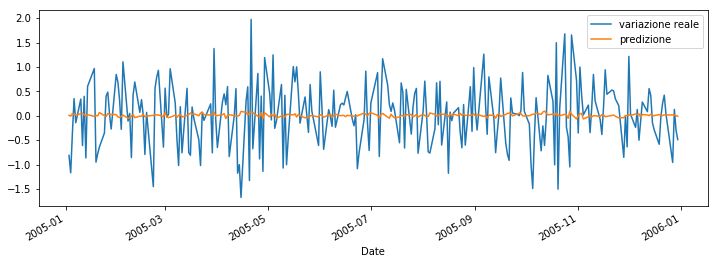

In [44]:
plt.figure(figsize=(12, 4))
y_val.plot()
y_val_pred.plot()
plt.legend(["variazione reale", "predizione"])

Il grafico evidenzia che il modello predice variazioni molto contenute rispetto a quelle reali

## Calcolo dell'Accuratezza

Per decidere che operazione effettuare tra comprare o vendere titoli, ci è sufficiente conoscere il **segno positivo o negativo** della variazione, che indica se a fine giornata il valore del titolo è maggiore o minore rispetto all'inizio

Misuriamo quindi **l'accuratezza** del modello come la percentuale di casi in cui il segno della predizione concorda con quello della variazione reale, indipendentemente dai loro valori esatti

Dalla serie `y_val` delle variazioni giornaliere deriviamo una serie `s_val` con i segni di tali variazioni, etichettandoli `Up` e `Down`
- la funzione `where(X, Y, Z)` restituisce un array con valore `Y` nelle posizioni in cui `X` è `True` e con valore `Z` nelle altre

In [45]:
s_val = pd.Series(np.where(y_val >= 0, "Up", "Down"), index=y_val.index)

Possiamo analizzare la distribuzione tra valori `Up` e `Down` con il metodo `value_counts`

In [48]:
s_val.value_counts()

Up      141
Down    111
dtype: int64

Creiamo allo stesso modo una serie `s_val_pred` con i segni predetti giornalmente dal modello

In [46]:
s_val_pred = pd.Series(np.where(y_val_pred >= 0, "Up", "Down"), index=y_val_pred.index)

In che percentuale di casi i segni combaciano?
- dato che i valori `True` e `False` contano come 1 e 0 rispettivamente, la funzione `mean` calcola in pratica la percentuale di valori `True`

In [47]:
np.mean(s_val == s_val_pred)

0.5317460317460317

Il modello prevede quindi correttamente il segno della predizione nel 53,2% circa dei casi

Per rendere più agevole il calcolo dell'accuratezza su altri modelli, incapsuliamo l'espressione sopra in una funzione `accuracy` che accetti una serie di predizioni come `s_val_pred` e restituisca la sua accuratezza

In [81]:
def accuracy(preds):
    return np.mean(s_val == preds)

Testiamo questa funzione accertandoci che applicandola a `s_val_pred` otteniamo lo stesso risultato sopra

In [82]:
accuracy(s_val_pred)

0.5317460317460317

### Baseline

Per valutare quanto questo risultato sia buono, vediamo quale sarebbe l'accuratezza in tre diversi casi dove non viene utilizzato alcun modello:
1. effettuare predizioni casuali con `Up` e `Down` equiprobabili
2. effettuare predizioni casuali con probabilità di `Up` e `Down` proporzionali alla loro frequenza
3. predire sempre `Up` o `Down`

Iniziamo col caso 1 creando una funzione che generi una serie di predizioni casuali con la stessa lunghezza e le stesse etichette di quelle generate dal modello

In [74]:
def random_preds():
    return pd.Series(np.random.choice(["Up", "Down"], len(y_val)), index=y_val.index)

Generiamo una serie casuale, impostando prima un seed per la riproducibilità

In [75]:
np.random.seed(42)
s_val_random = random_preds()

Qual è l'accuratezza di questa serie di "predizioni"?

In [76]:
np.mean(s_val == s_val_random)

0.47619047619047616

Con i valori in `s_val_random` otteniamo 47,6% di accuratezza, ma essendo generati a caso un solo risultato non è significativo: per questo generiamo una lista di 100.000 serie casuali...

In [77]:
np.random.seed(42)
s_val_random = [random_preds() for i in range(100000)]

...valutiamo l'accuratezza di ciascuna ed estraiamo l'accuratezza media

In [84]:
np.mean([accuracy(preds) for preds in s_val_random])

0.49997376984126984

Queste predizioni casuali hanno un valore atteso di accuratezza pari al 50%

Valutiamo il secondo caso, in cui le probabilità di `Up` e `Down` sono proporzionali alla loro frequenza nel training set

Otteniamo una serie `s_train` allo stesso modo di `s_val`

In [85]:
s_train = pd.Series(np.where(y_train >= 0, "Up", "Down"), index=y_train.index)

Usiamo il metodo `value_counts` con l'opzione `normalize` per ottenere le frequenze relative di `Up` e `Down` nella serie

In [88]:
s_train_freqs = s_train.value_counts(normalize=True)
s_train_freqs

Up      0.506507
Down    0.493493
dtype: float64

Creiamo una funzione simile a `random_preds` per generare predizioni casuali rispettando tale distribuzione

In [89]:
def random_preds_prop():
    return pd.Series(np.random.choice(s_train_freqs.index, len(y_val), p=s_train_freqs),
                     index=y_val.index)

Anche con questa funzione creiamo 100.000 serie di predizioni casuali e valutiamo l'accuratezza media

In [90]:
np.random.seed(42)
s_val_random_prop = [random_preds_prop() for i in range(100000)]

In [91]:
np.mean([accuracy(preds) for preds in s_val_random_prop])

0.5006585714285714

Anche in questo caso l'accuratezza attesa è intorno al 50%

Infine, per calcolare l'accuratezza che otterremo predicendo sempre `Up` o `Down`, è sufficiente calcolare le frequenze relative di tali valori nel periodo di validazione

In [93]:
s_val.value_counts(normalize=True)

Up      0.559524
Down    0.440476
dtype: float64

Predicendo sempre `Up` avremmo un'accuratezza intorno al 56%, superiore quindi a quella del modello

Tuttavia, per evidenziare la reale utilità del modello, eseguiamo un altro tipo di valutazione...

## Simulazione Trading

Quanto guadagnerebbe un trader che compra e vende titoli in base alle predizioni del modello?

Ipotizziamo un trader che all'inizio di ogni giornata compra o vende (allo scoperto) un singolo titolo al suo valore di apertura a seconda della predizione del modello, per poi rivenderlo o ricomprarlo al suo valore di chiusura

Siano $O,C,\hat{C}$ rispettivamente il valore di apertura, quello di chiusura reale e quello di chiusura predetto, il guadagno (o perdita se negativo) di ciascuna giornata sarà:

$$ R = \left\{\begin{array}{lr}C-O&:\hat{C}>O\\O-C&:\hat{C}<O\end{array}\right. $$

Calcoliamo una serie con la differenza $C-O$ limitatamente al periodo di validazione

In [53]:
diff_val = sp500.loc[y_val.index, "Close"] - sp500.loc[y_val.index, "Open"]

Definiamo quindi una funzione che calcoli il guadagno totale utilizzando la logica descritta sopra nell'arco del periodo di validazione
- in input alla funzione viene passata la serie di indicazioni `Up` e `Down` fornite dal modello
- per ogni giorno il guadagno è pari a `diff_val` ($C-O$) se il modello ha previsto `Up` o al suo opposto ($O-C$) se h previsto `Down`
- viene restituita la somma dei guadagni giornalieri

In [57]:
def gain(pred):
    return np.where(
        pred == "Up",
        diff_val,   # giorni "Up":   C-O
        -diff_val   # giorni "Down": O-C
    ).sum()

Applichiamo tale funzione alle predizioni ottenute dal modello di regressione lineare

In [94]:
gain(s_val_pred)

89.85949600000049

Seguendo la logica descritta sopra e affidandosi a questo modello di regressione lineare, un trader avrebbe quindi un guadagno complessivo di circa 90\\$
- tale guadagno potrebbe essere ovviamente maggiore comprando/vendendo un numero maggiore di titoli ogni giorno

### Baseline

Come abbiamo fatto per l'accuratezza, valutiamo il guadagno che otterremmo senza usare un modello

Calcoliamo il guadagno medio ottenuto con predizioni casuali con probabilità di `Up` e `Down` equilibrate oppure tarate sul training set

In [95]:
np.mean([gain(preds) for preds in s_val_random])

0.0007614430400074707

In [96]:
np.mean([gain(preds) for preds in s_val_random_prop])

-0.13001298576000012

Il guadagno medio con predizioni casuali è quindi praticamente nullo: a seconda del caso possono verificarsi con la stessa probabilità guadagni elevati o perdite elevate

Se tutti i giorni comprassi un titolo a inizio giornata e lo rivendessi a fine giornata, il guadagno per qualsiasi giorno sarebbe pari a $C-O$; posso quindi calcolare il guadagno complessivo che avrei sommando tutti i valori della serie `diff_val`

In [59]:
diff_val.sum()

35.87976200000003

Il guadagno sarebbe quindi di circa 36\\$, contro i 90\\$ (ovvero il 250% circa) portati dal modello di regressione lineare

Se tutti i giorni vendessi un titolo e lo ricomprassi a fine giornata, il guadagno sarebbe esattamente l'opposto, quindi perderei 36\\$

## Calcolo del ROI

Il ROI (_Return on Investment_) esprime il guadagno di una o più operazioni in borsa in rapporto all'investimento iniziale.

La cifra investita in questo caso è pari al valore del titolo all'apertura che varia giornalmente, per fare una stima del ROI usiamo la media di tale valore nel periodo di training

In [65]:
mean_open_train = sp500.loc[y_train.index, "Open"].mean()
mean_open_train

1069.3752966886886

Definiamo quindi una funzione che calcoli il ROI sfruttando quella già esistente per il guadagno

In [66]:
def roi(preds):
    return gain(preds) / mean_open_train

Ad esempio il ROI ottenuto tramite il modello di regressione lineare è pari all'8,4%

In [67]:
roi(s_val_pred)

0.08402989696718229

Quello ottenuto predicendo sempre `Up` è invece pari al 3,4%

In [98]:
roi(pd.Series("Up", index=y_val.index))

0.03355207672283192